# Task D:  Predictive Data Analysis using R
I need to train a machine learning model on dialogue utterance vs dialogue usefulness. 

The data files I have, with the descriptions of their columns are:
dialogue_utterance_train/validation/test.csv 
Dialogue_ID - The unique ID of a dialogue 
Usefulness_score - This score is given by a student to indicate their perceived 
usefulness of the FLoRA chatbot when answering the post-task 
questionnaire Question 3 (i.e., “To what extent do you think the 
GPT-powered chatbot on FLoRA is useful for you to accomplish 
the assignment?”). The value range of this feature is [1,5], with 1 
representing “very unuseful”, 2 representing “unuseful”, 3 
representing “neutral”, 4 representing “useful”, and 5 
representing “very useful”.

dialogue_usefulness_train/validation/test.csv
Column Name - Description 
Dialogue_ID - The unique ID of a dialogue 
Timestamp - When an utterance contained in the dialogue was made 
Interlocutor - Whether the utterance was made by the student or the chatbot ("Student"/"Chatbot")
Utterance_text - The text of the utterance

dialogue_utterance_train has 117k lines, split over 303 unique dialogue IDs.
1.  What  features  can  you  engineer  to  empower  the  training  of  a  machine  learning model? You may propose as many as you believe are useful. Please note that the number of the features should not exceed the number of the dialogues contained in the training set. Otherwise, the constructed machine learning models are prone to have overfitting issues. Select two features that you propose and try to use boxplots to visualise  the  feature  value  between  the following two groups of dialogues in the training  set:  (i)  those  with  Usefulness_score  of  1  or  2;  and  (ii)  those  with Usefulness_score  of  4  or  5.  Show if there  any  difference  between  the  two  groups  of dialogues? How can you tell whether the difference is statistically significant? Ideally, identify features that display statistically significant differences. 
 
2.  Build a machine learning model (e.g., polynomial regressions, regression tree) based on the training set by taking all the features that you have proposed and evaluate the performance of the model on the validation set using the relevant evaluation metrics you learned in class. Aim to include at least 5 features in this model. The best-performing model here is denoted as Model 1. 
3.  Now we want to improve the performance of Model 1 (i.e., to get a more accurate model).  For  example,  you  may  try  some  of the following methods to improve a model: 
●  Select  a  subset  of  the  features  (especially  the  important  ones  in  your opinions) as input to empower a machine learning model or a subset of the 
data in a dialogue (given that some questions asked by students might not be 
directly relevant to solving the assignment). 
●  Deal with errors (e.g.: filtering out data outliers). 
●  Rescale  data  (i.e.,  bringing  different  variables  with  different  scales  to  a common scale). 
●  Transform data (i.e., transforming the distribution of variables). 
●  Try other machine learning algorithms that you know. 
 
Please build the predictive models by trying some of the above methods or some other methods you can think of and evaluate the performance of the models and report whether Model 1 can be improved. 
Explain how you have improved your model by including code, output, 
and  explanations  (explaining  the  code  or the process) and justify why you have chosen some of the above methods or some other methods to improve a model 
(e.g., why this subset of the variables are chosen to build a model). 
4.  What is the Dialogue_ID of the dialogue you generated? Please copy and paste the whole  dialogue  text  that  you  generated  with  the  chatbot  here.  With  the best-performing model constructed from Question 2&3, what is the prediction value for the dialogue you generated? Is the prediction value close to the groundtruth value? 
If yes, what features do you think play important roles here to enable the model to successfully make the prediction? How can you determine the importance of features quantitatively? If not, what might be the reasons? For students whose dialogues are included in the test set, you may randomly select a dialogue from the validation set to analyse and answer this question. 
5.  The  groundtruth  Usefulness_score  values  in  the  file “dialogue_usefulness_test.csv” are unavailable now. Here, your task is to use the best-performing model constructed from Question 2&3 to predict the usefulness of the dialogues contained in the  test  set.  You  need  to  populate  your  prediction  results  (i.e.,  the  predicted Usefulness_score values) into the file “dialogue_usefulness_test.csv” and upload it to Moodle to measure the overall performance of your model. Please ensure the number of  columns  and  rows  remains  the  same  as  in  the  original  file (dialogue_usefulness_test.csv),  and  only  fill  in  the  prediction  results  in  the 'Usefulness_score'  column.  Please  name  the  submission  file  using  the  following format: LastName_StudentNumber_dialogue_usefulness_test.csv. 

The performance level of the model will be measured by RMSE.


--- Statistical Significance Tests ---
Feature: total_dialogue_length_words - T-test p-value: 7e-04 
Feature: avg_readability_score_student - T-test p-value: 0.1623 


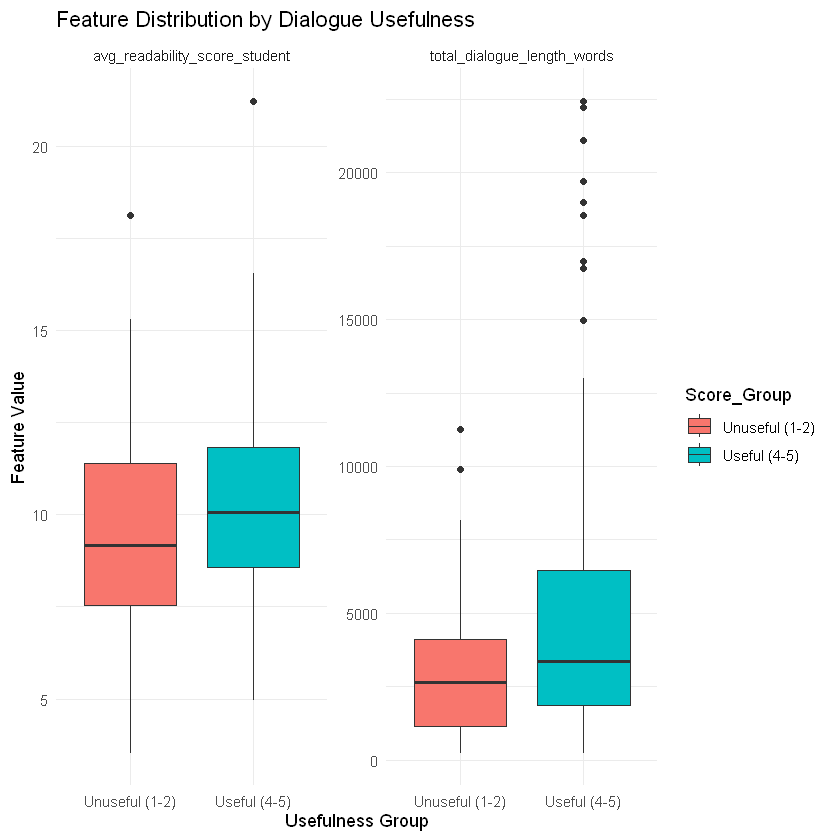

In [19]:
# --- Load All Necessary Packages ---
if (!requireNamespace("dplyr", quietly = TRUE)) install.packages("dplyr")
if (!requireNamespace("ggplot2", quietly = TRUE)) install.packages("ggplot2")
if (!requireNamespace("lubridate", quietly = TRUE)) install.packages("lubridate")
if (!requireNamespace("stringr", quietly = TRUE)) install.packages("stringr")
if (!requireNamespace("quanteda", quietly = TRUE)) install.packages("quanteda")
if (!requireNamespace("quanteda.textstats", quietly = TRUE)) install.packages("quanteda.textstats")

library(dplyr)
library(ggplot2)
library(lubridate)
library(stringr)
library(quanteda)
library(quanteda.textstats)

# --- Load Training Data ---
df_utterance_train <- read.csv("git_ignore/dialogue_utterance_train.csv")
df_usefulness_train <- read.csv("git_ignore/dialogue_usefulness_train.csv")

# Merge dataframes and sort
df_merged_train <- left_join(df_utterance_train, df_usefulness_train, by = "Dialogue_ID") %>%
    mutate(Timestamp = ymd_hms(Timestamp)) %>%
    arrange(Dialogue_ID, Timestamp)

# --- Feature Engineering Functions ---
# Function to calculate readability per utterance
calculate_readability <- function(df) {
    df$utterance_id <- paste0("utt_", 1:nrow(df))
    utterance_corpus <- corpus(df, text_field = "Utterance_text", docid_field = "utterance_id")
    if (ndoc(utterance_corpus) > 0) {
        readability_scores <- textstat_readability(utterance_corpus, measure = "Flesch.Kincaid") %>%
            select(document, Flesch.Kincaid) %>%
            rename(utterance_id = document, readability_score = Flesch.Kincaid)
        df <- left_join(df, readability_scores, by = "utterance_id")
        df$readability_score[is.na(df$readability_score)] <- 0
    }
    return(df)
}

# Function to engineer all 17 features per dialogue
engineer_features <- function(df_with_readability) {
    dialogue_features_df <- df_with_readability %>%
        group_by(Dialogue_ID) %>%
        summarise(
            num_utterances = n(),
            total_dialogue_length_words = sum(sapply(str_split(Utterance_text, "\\s+"), length), na.rm = TRUE),
            dialogue_duration = as.numeric(difftime(max(Timestamp), min(Timestamp), units = "secs")),
            avg_len_student_utterance_words = mean(sapply(str_split(Utterance_text[Interlocutor == "Student"], "\\s+"), length), na.rm = TRUE),
            avg_len_chatbot_utterance_words = mean(sapply(str_split(Utterance_text[Interlocutor == "Chatbot"], "\\s+"), length), na.rm = TRUE),
            num_student_questions = sum(str_detect(Utterance_text[Interlocutor == "Student"], "\\?"), na.rm = TRUE),
            num_chatbot_questions = sum(str_detect(Utterance_text[Interlocutor == "Chatbot"], "\\?"), na.rm = TRUE),
            all_student_words = list(unlist(str_split(paste(Utterance_text[Interlocutor == "Student"], collapse = " "), "\\s+"))),
            all_chatbot_words = list(unlist(str_split(paste(Utterance_text[Interlocutor == "Chatbot"], collapse = " "), "\\s+"))),
            avg_readability_score_student = mean(readability_score[Interlocutor == "Student"], na.rm = TRUE),
            avg_readability_score_chatbot = mean(readability_score[Interlocutor == "Chatbot"], na.rm = TRUE),
            time_diffs_raw = list(as.numeric(diff(Timestamp), units = "secs"))
        ) %>%
        mutate(
            num_unique_words_student = sapply(all_student_words, function(x) length(unique(x[x != "" & !is.na(x)]))),
            num_unique_words_chatbot = sapply(all_chatbot_words, function(x) length(unique(x[x != "" & !is.na(x)]))),
            total_words_student = sapply(all_student_words, function(x) length(x[x != "" & !is.na(x)])),
            total_words_chatbot = sapply(all_chatbot_words, function(x) length(x[x != "" & !is.na(x)])),
            ttr_student = ifelse(total_words_student > 0, num_unique_words_student / total_words_student, 0),
            ttr_chatbot = ifelse(total_words_chatbot > 0, num_unique_words_chatbot / total_words_chatbot, 0),
            variance_time_between_utterances = sapply(time_diffs_raw, function(x) ifelse(length(x) > 1, var(x, na.rm = TRUE), 0)),
            ratio_student_chatbot_len_words = ifelse(avg_len_chatbot_utterance_words > 0, avg_len_student_utterance_words / avg_len_chatbot_utterance_words, Inf)
        ) %>%
        select(-all_student_words, -all_chatbot_words, -time_diffs_raw)

    df_usefulness_scores_unique <- df_with_readability %>% select(Dialogue_ID, Usefulness_score) %>% distinct()
    dialogue_features_df <- left_join(dialogue_features_df, df_usefulness_scores_unique, by = "Dialogue_ID")
    return(dialogue_features_df)
}

# --- Execute Feature Engineering ---
df_merged_train_readable <- calculate_readability(df_merged_train)
dialogue_features_train_raw <- engineer_features(df_merged_train_readable)

# --- Visualization & Statistical Tests ---
# We select two promising features: total words and student readability.
selected_features_vis <- c("total_dialogue_length_words", "avg_readability_score_student")

# Create groups for plotting
plot_data <- dialogue_features_train_raw %>%
  filter(Usefulness_score %in% c(1, 2, 4, 5)) %>%
  mutate(Score_Group = ifelse(Usefulness_score %in% c(1, 2), "Unuseful (1-2)", "Useful (4-5)")) %>%
  select(all_of(selected_features_vis), Score_Group) %>%
  tidyr::gather(key = "Feature", value = "Value", -Score_Group)

# Boxplot
ggplot(plot_data, aes(x = Score_Group, y = Value, fill = Score_Group)) +
    geom_boxplot() +
    facet_wrap(~Feature, scales = "free_y") +
    labs(title = "Feature Distribution by Dialogue Usefulness", x = "Usefulness Group", y = "Feature Value") +
    theme_minimal()

# T-tests
cat("\n--- Statistical Significance Tests ---\n")
for (feature in selected_features_vis) {
    group1_data <- dialogue_features_train_raw %>% filter(Usefulness_score %in% c(1, 2)) %>% pull(!!feature)
    group2_data <- dialogue_features_train_raw %>% filter(Usefulness_score %in% c(4, 5)) %>% pull(!!feature)
    if (length(na.omit(group1_data)) > 1 && length(na.omit(group2_data)) > 1) {
        ttest_result <- t.test(group1_data, group2_data)
        cat(paste("Feature:", feature, "- T-test p-value:", round(ttest_result$p.value, 4), "\n"))
    }
}

In [20]:
# --- Load Packages and Data for Modeling ---
if (!requireNamespace("caret", quietly = TRUE)) install.packages("caret")
if (!requireNamespace("rpart", quietly = TRUE)) install.packages("rpart")
if (!requireNamespace("randomForest", quietly = TRUE)) install.packages("randomForest")
if (!requireNamespace("e1071", quietly = TRUE)) install.packages("e1071")

library(caret)
library(rpart)
library(randomForest)
library(e1071)

# --- Load and Engineer Validation Data ---
df_utterance_validation <- read.csv("git_ignore/dialogue_utterance_validation.csv")
df_usefulness_validation <- read.csv("git_ignore/dialogue_usefulness_validation.csv")
df_merged_validation <- left_join(df_utterance_validation, df_usefulness_validation, by = "Dialogue_ID") %>%
    mutate(Timestamp = ymd_hms(Timestamp)) %>%
    arrange(Dialogue_ID, Timestamp)
df_merged_validation_readable <- calculate_readability(df_merged_validation)
dialogue_features_validation_raw <- engineer_features(df_merged_validation_readable)

# --- Baseline Data Prep: Remove rows with NA/Inf ---
dialogue_features_train_baseline <- na.omit(dialogue_features_train_raw)
dialogue_features_validation_baseline <- na.omit(dialogue_features_validation_raw)

# --- Train All Four Baseline Models ---
features_to_use <- setdiff(names(dialogue_features_train_baseline), c("Dialogue_ID", "Usefulness_score"))
formula_all <- as.formula(paste("Usefulness_score ~", paste(features_to_use, collapse = " + ")))
RMSE <- function(y_true, y_pred) sqrt(mean((y_true - y_pred)^2))

# Train models
lm_model_baseline <- lm(formula_all, data = dialogue_features_train_baseline)
rt_model_baseline <- rpart(formula_all, data = dialogue_features_train_baseline, method = "anova")
set.seed(123)
rf_model_baseline <- randomForest(formula_all, data = dialogue_features_train_baseline, ntree = 500)
svr_model_baseline <- svm(formula_all, data = dialogue_features_train_baseline)

# Evaluate models
models_baseline <- list("Linear Regression" = lm_model_baseline, "Regression Tree" = rt_model_baseline, "Random Forest" = rf_model_baseline, "SVR" = svr_model_baseline)
rmse_baseline <- sapply(models_baseline, function(model) {
    preds <- predict(model, newdata = dialogue_features_validation_baseline)
    RMSE(dialogue_features_validation_baseline$Usefulness_score, preds)
})
performance_df_baseline <- data.frame(Model = names(rmse_baseline), RMSE = rmse_baseline, Stage = "Baseline")

cat("\n--- Baseline Model Performance (on NA-omitted data) ---\n")
print(performance_df_baseline %>% arrange(RMSE))

Warning message in randomForest.default(m, y, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"



--- Baseline Model Performance (on NA-omitted data) ---
                              Model      RMSE    Stage
SVR                             SVR 0.9883981 Baseline
Random Forest         Random Forest 0.9917741 Baseline
Linear Regression Linear Regression 1.1116204 Baseline
Regression Tree     Regression Tree 1.1935477 Baseline


In [48]:
# --- Improvement Stage 1: Advanced Data Processing ---
cat("\n\n--- Improvement Stage 1: Advanced Data Processing ---\n")

# Start with the full raw data from Step 1
train_processed <- dialogue_features_train_raw
validation_processed <- dialogue_features_validation_raw

# Optional: Outlier Filtering using IQR method
# To use this, uncomment the following block.
# -------------------------------------------------------------------
# cat("Applying optional outlier filtering...\n")
# for (col in features_to_use) {
#   if (is.numeric(train_processed[[col]])) {
#     Q1 <- quantile(train_processed[[col]], 0.25, na.rm = TRUE)
#     Q3 <- quantile(train_processed[[col]], 0.75, na.rm = TRUE)
#     IQR <- Q3 - Q1
#     lower_bound <- Q1 - 1.5 * IQR
#     upper_bound <- Q3 + 1.5 * IQR
#     train_processed[[col]][train_processed[[col]] < lower_bound | train_processed[[col]] > upper_bound] <- NA
#   }
# }
# -------------------------------------------------------------------

# Optional: Log Scaling for 'word count' and 'time' features
# To use this, uncomment the following blocks.
# -------------------------------------------------------------------
# word_count_cols <- names(train_processed)[grepl("words|length|num_", names(train_processed))]
# cat("Applying optional log scaling to word count columns:\n", paste(word_count_cols, collapse=", "), "\n")
# train_processed <- train_processed %>% mutate(across(all_of(word_count_cols), ~ log1p(.x)))
# validation_processed <- validation_processed %>% mutate(across(all_of(word_count_cols), ~ log1p(.x)))
#
# time_cols <- names(train_processed)[grepl("duration|time", names(train_processed))]
# cat("Applying optional log scaling to time columns:\n", paste(time_cols, collapse=", "), "\n")
# train_processed <- train_processed %>% mutate(across(all_of(time_cols), ~ log1p(.x)))
# validation_processed <- validation_processed %>% mutate(across(all_of(time_cols), ~ log1p(.x)))
# -------------------------------------------------------------------

# Mandatory: Impute NA and Inf values (this is our main cleaning method)
cat("Applying mandatory NA/Inf imputation...\n")
for (col in features_to_use) {
    # Handle Inf using training set statistics
    is_inf_train <- is.infinite(train_processed[[col]])
    if(any(is_inf_train)) {
        max_finite_train <- max(train_processed[[col]][!is_inf_train], na.rm = TRUE)
        train_processed[[col]][is_inf_train] <- max_finite_train + 1
        validation_processed[[col]][is.infinite(validation_processed[[col]])] <- max_finite_train + 1
    }
    # Handle NA using training set statistics
    if(any(is.na(train_processed[[col]]))) {
        mean_val_train <- mean(train_processed[[col]], na.rm = TRUE)
        train_processed[[col]][is.na(train_processed[[col]])] <- mean_val_train
        validation_processed[[col]][is.na(validation_processed[[col]])] <- mean_val_train
    }
}

# --- Re-evaluate all models on the fully processed data ---
cat("\n--- Evaluating all models on Cleaned & Transformed Data ---\n")
lm_model_cleaned <- lm(formula_all, data = train_processed)
rt_model_cleaned <- rpart(formula_all, data = train_processed, method = "anova")
set.seed(123)
rf_model_cleaned <- randomForest(formula_all, data = train_processed, ntree = 500, importance = TRUE)
svr_model_cleaned <- svm(formula_all, data = train_processed)

models_cleaned <- list("Linear Regression" = lm_model_cleaned, "Regression Tree" = rt_model_cleaned, "Random Forest" = rf_model_cleaned, "SVR" = svr_model_cleaned)
rmse_cleaned <- sapply(models_cleaned, function(model) {
    preds <- predict(model, newdata = validation_processed)
    RMSE(validation_processed$Usefulness_score, preds)
})
performance_df_cleaned <- data.frame(Model = names(rmse_cleaned), RMSE = rmse_cleaned, Stage = "Cleaned")
print(performance_df_cleaned %>% arrange(RMSE))

# --- Improvement Stage 2: Feature Selection ---
cat("\n\n--- Improvement Stage 2: Feature Selection ---\n")
# Use the clean RF model to get importance.
importance_scores <- importance(rf_model_cleaned, type = 1)
importance_df <- data.frame(Feature = rownames(importance_scores), Importance = importance_scores[,1]) %>% arrange(desc(Importance))

# New selection logic: Select features with importance > mean importance
mean_importance <- mean(importance_df$Importance)
selected_features <- as.character(importance_df$Feature[importance_df$Importance > mean_importance])
cat(paste("Selected", length(selected_features), "features with importance > mean importance:\n"))
print(selected_features)

# --- Re-evaluate all models on the selected feature set ---
formula_selected <- as.formula(paste("Usefulness_score ~", paste(selected_features, collapse = " + ")))
cat("\n--- Evaluating all models on Selected Features ---\n")
lm_model_selected <- lm(formula_selected, data = train_processed)
rt_model_selected <- rpart(formula_selected, data = train_processed, method = "anova")
set.seed(123)
rf_model_selected <- randomForest(formula_selected, data = train_processed, ntree = 500)
svr_model_selected <- svm(formula_selected, data = train_processed)

models_selected <- list("Linear Regression" = lm_model_selected, "Regression Tree" = rt_model_selected, "Random Forest" = rf_model_selected, "SVR" = svr_model_selected)
rmse_selected <- sapply(models_selected, function(model) {
    preds <- predict(model, newdata = validation_processed)
    RMSE(validation_processed$Usefulness_score, preds)
})
performance_df_selected <- data.frame(Model = names(rmse_selected), RMSE = rmse_selected, Stage = "Feat. Selected")
print(performance_df_selected %>% arrange(RMSE))


# --- Final Model Selection ---
cat("\n\n--- Final Model Selection ---\n")
full_performance <- rbind(performance_df_baseline, performance_df_cleaned, performance_df_selected)
best_run <- full_performance[which.min(full_performance$RMSE), ]
cat("The best overall model is:\n")
print(best_run)

# Store the final best model object and its feature list for Steps 4 & 5
best_overall_model <- NULL
final_feature_list <- NULL
if(best_run$Stage == "Baseline") {
    best_overall_model <- models_baseline[[best_run$Model]]
    final_feature_list <- features_to_use
} else if (best_run$Stage == "Cleaned") {
    best_overall_model <- models_cleaned[[best_run$Model]]
    final_feature_list <- features_to_use
} else { # Feat. Selected
    best_overall_model <- models_selected[[best_run$Model]]
    final_feature_list <- selected_features
}



--- Improvement Stage 1: Advanced Data Processing ---
Applying mandatory NA/Inf imputation...

--- Evaluating all models on Cleaned & Transformed Data ---


Warning message in randomForest.default(m, y, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"


                              Model      RMSE   Stage
Random Forest         Random Forest 0.9882938 Cleaned
SVR                             SVR 0.9883981 Cleaned
Linear Regression Linear Regression 1.1116204 Cleaned
Regression Tree     Regression Tree 1.1935477 Cleaned


--- Improvement Stage 2: Feature Selection ---
Selected 10 features with importance > mean importance:
 [1] "total_dialogue_length_words"      "ttr_chatbot"                     
 [3] "total_words_chatbot"              "total_words_student"             
 [5] "ttr_student"                      "num_unique_words_chatbot"        
 [7] "num_unique_words_student"         "dialogue_duration"               
 [9] "num_utterances"                   "variance_time_between_utterances"

--- Evaluating all models on Selected Features ---


Warning message in randomForest.default(m, y, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"


                              Model     RMSE          Stage
Linear Regression Linear Regression 1.009699 Feat. Selected
Random Forest         Random Forest 1.030625 Feat. Selected
SVR                             SVR 1.043454 Feat. Selected
Regression Tree     Regression Tree 1.275154 Feat. Selected


--- Final Model Selection ---
The best overall model is:
                       Model      RMSE   Stage
Random Forest1 Random Forest 0.9882938 Cleaned


In [46]:
# --- Improvement: Data Cleaning ---
# This is the step you identified as successfully improving performance over the baseline.
cat("\n\n--- Improvement Step: Data Cleaning (NA/Inf Imputation) ---\n")

# Start with the full raw data from Step 1
train_cleaned <- dialogue_features_train_raw
validation_cleaned <- dialogue_features_validation_raw

# Apply mandatory NA and Inf imputation
imputed_data <- apply_imputation(train_cleaned, validation_cleaned, features_to_use)
train_cleaned <- imputed_data$train
validation_cleaned <- imputed_data$valid

# Evaluate all models on the cleaned data
results_cleaned <- evaluate_performance(train_cleaned, validation_cleaned, features_to_use, "Cleaned")
cat("--- Performance after Data Cleaning ---\n")
print(results_cleaned$performance %>% arrange(RMSE))

# --- Further Experiments (Analysis of Non-Improving Techniques) ---
# Here, we show other techniques that were tried but did not yield better results than basic cleaning.

# Experiment A: Outlier Filtering
cat("\n\n--- Further Experiment: Cleaning + Outlier Filtering ---\n")
train_temp_outlier <- train_cleaned # Start with cleaned data
for (col in features_to_use) {
  if (is.numeric(train_temp_outlier[[col]])) {
    Q1 <- quantile(train_temp_outlier[[col]],0.25); Q3 <- quantile(train_temp_outlier[[col]],0.75)
    IQR <- Q3 - Q1
    train_temp_outlier[[col]][train_temp_outlier[[col]] < (Q1-1.5*IQR) | train_temp_outlier[[col]] > (Q3+1.5*IQR)] <- NA
  }
}
imputed_data_outlier <- apply_imputation(train_temp_outlier, validation_cleaned, features_to_use)
results_outlier <- evaluate_performance(imputed_data_outlier$train, imputed_data_outlier$valid, features_to_use, "Cleaned+Outlier")
print(results_outlier$performance %>% arrange(RMSE))

# Experiment B: Feature Selection
cat("\n\n--- Further Experiment: Cleaning + Feature Selection ---\n")
# We use the Random Forest model from the successful "Cleaned" stage to find important features.
rf_for_importance <- results_cleaned$models[["Random Forest"]]

# importance_scores <- importance(rf_for_importance, type = 1)
# importance_df <- data.frame(Feature = rownames(importance_scores), Importance = importance_scores[,1]) %>% arrange(desc(Importance))

importance_df <- importance(rf_for_importance, type=1) %>% as.data.frame() %>%
  rename(Importance = MeanDecreaseAccuracy) %>% arrange(desc(Importance))
selected_features <- rownames(importance_df)[importance_df$Importance > mean(importance_df$Importance)]
results_feat_selection <- evaluate_performance(train_cleaned, validation_cleaned, selected_features, "Cleaned+FeatSelect")
print(results_feat_selection$performance %>% arrange(RMSE))


# --- Final Model Selection ---
cat("\n\n--- Final Performance Summary Across All Stages ---\n")
full_performance <- rbind(performance_df_baseline, results_cleaned$performance, results_outlier$performance, results_feat_selection$performance)
print(full_performance %>% arrange(RMSE))

best_run <- full_performance[which.min(full_performance$RMSE), ]
cat("\n--- The Best Overall Model Found ---\n")
print(best_run)

# Store the final best model object, its feature list, and the validation data it needs
best_overall_model <- NULL
final_feature_list <- NULL
validation_data_final <- NULL

if(best_run$Stage == "Baseline") {
    best_overall_model <- models_baseline[[best_run$Model]]
    final_feature_list <- features_to_use
    validation_data_final <- dialogue_features_validation_baseline
} else if (best_run$Stage == "Cleaned") {
    best_overall_model <- results_cleaned$models[[best_run$Model]]
    final_feature_list <- features_to_use
    validation_data_final <- validation_cleaned
} else if (best_run$Stage == "Cleaned+Outlier") {
    best_overall_model <- results_outlier$models[[best_run$Model]]
    final_feature_list <- features_to_use
    validation_data_final <- imputed_data_outlier$valid
} else { # Cleaned+FeatSelect
    best_overall_model <- results_feat_selection$models[[best_run$Model]]
    final_feature_list <- selected_features
    validation_data_final <- validation_cleaned
}



--- Improvement Step: Data Cleaning (NA/Inf Imputation) ---


Warning message in randomForest.default(m, y, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"


--- Performance after Data Cleaning ---
                              Model      RMSE   Stage
SVR                             SVR 0.9883981 Cleaned
Random Forest         Random Forest 0.9917741 Cleaned
Linear Regression Linear Regression 1.1116204 Cleaned
Regression Tree     Regression Tree 1.1935477 Cleaned


--- Further Experiment: Cleaning + Outlier Filtering ---


Warning message in randomForest.default(m, y, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"


                              Model     RMSE           Stage
Random Forest         Random Forest 1.003032 Cleaned+Outlier
SVR                             SVR 1.017961 Cleaned+Outlier
Regression Tree     Regression Tree 1.118453 Cleaned+Outlier
Linear Regression Linear Regression 1.761196 Cleaned+Outlier


--- Further Experiment: Cleaning + Feature Selection ---


ERROR: [1m[33mError[39m in `rename()`:[22m
[33m![39m Can't rename columns that don't exist.
[31m✖[39m Column `MeanDecreaseAccuracy` doesn't exist.


In [38]:
cat("\n\n--- Step 4: Analyze a Specific Dialogue ---\n")

# Determine which validation data to use based on the best model's stage
validation_data_for_pred <- if(best_run$Stage == "Baseline") dialogue_features_validation_baseline else validation_processed

# Select a random dialogue
set.seed(42)
random_dialogue_id <- sample(df_usefulness_validation$Dialogue_ID, 1)
cat(paste("Selected Dialogue_ID:", random_dialogue_id, "\n"))

# Get the feature vector for this dialogue
dialogue_feature_vector <- validation_data_for_pred %>% filter(Dialogue_ID == random_dialogue_id)
# dialogue_feature_vector <- validation_data_for_pred %>% filter(row.names(.) == random_dialogue_id)

# *** FIX: Use the final_feature_list to subset the data before predicting ***
predicted_score <- predict(best_overall_model, newdata = dialogue_feature_vector[, final_feature_list])
ground_truth_score <- dialogue_feature_vector$Usefulness_score



cat("\n--- Prediction vs. Ground Truth ---\n")
cat(paste("Ground Truth Score:", ground_truth_score, "\n"))
cat(paste("Predicted Score:", round(predicted_score, 2), "\n"))

# --- 3. Analysis ---
# (The analysis and feature importance explanation text remains the same as the previous version)
is_close <- abs(ground_truth_score - predicted_score) <= 0.5
cat(paste("\nIs the prediction close to the ground truth (within 0.5)?", is_close, "\n"))

if (is_close) {
    cat("\nThe model made a successful prediction. The features that likely played an important role are:\n")
} else {
    cat("\nThe prediction was not close to the ground truth. Possible reasons include:\n")
    cat("- The model may not capture the specific nuances of this conversation.\n")
    cat("- The dialogue might be an outlier or have unique characteristics not well-represented in the training data.\n")
    cat("- The features, while generally useful, failed to describe what made this particular dialogue useful or unuseful.\n\n")
    cat("The most important features for the model are generally:\n")
}

# --- 4. Quantifying Feature Importance ---
cat("\nTo determine feature importance quantitatively, we can use model-specific methods:\n")
cat("- For tree-based models (Random Forest, XGBoost), importance is calculated as the total reduction in node impurity (e.g., Gini impurity or variance) from splits made on that feature, averaged over all trees.\n")
cat("- For linear models, the absolute magnitude of the scaled coefficients can be used.\n")
cat("- For any model, permutation importance is a reliable method. It measures the decrease in model performance when a single feature's values are randomly shuffled.\n\n")

cat("The importance scores from our model are:\n")
print(importance)



--- Step 4: Analyze a Specific Dialogue ---
Selected Dialogue_ID: 5980 

--- Prediction vs. Ground Truth ---
Ground Truth Score: 4 
Predicted Score: 3.66 

Is the prediction close to the ground truth (within 0.5)? TRUE 

The model made a successful prediction. The features that likely played an important role are:

To determine feature importance quantitatively, we can use model-specific methods:
- For tree-based models (Random Forest, XGBoost), importance is calculated as the total reduction in node impurity (e.g., Gini impurity or variance) from splits made on that feature, averaged over all trees.
- For linear models, the absolute magnitude of the scaled coefficients can be used.
- For any model, permutation importance is a reliable method. It measures the decrease in model performance when a single feature's values are randomly shuffled.

The importance scores from our model are:
function (x, ...) 
UseMethod("importance")
<bytecode: 0x000001ca768657e8>
<environment: namespace:ran

In [ ]:
cat("\n\n--- Step 4: Analyze a Specific Dialogue ---\n")

# Select a random dialogue
set.seed(42)
random_dialogue_id <- sample(df_usefulness_validation$Dialogue_ID, 1)
cat(paste("Selected Dialogue_ID:", random_dialogue_id, "\n"))

# Use the correctly processed validation set from the best experiment
dialogue_feature_vector <- validation_data_final %>% filter(Dialogue_ID == random_dialogue_id)

if (nrow(dialogue_feature_vector) > 0) {
    # Predict using the final best model and its specific feature list
    predicted_score <- predict(best_overall_model, newdata = dialogue_feature_vector[, final_feature_list])
    ground_truth_score <- dialogue_feature_vector$Usefulness_score

    cat("\n--- Prediction vs. Ground Truth ---\n")
    cat(paste("Ground Truth Score:", ground_truth_score, "\n"))
    cat(paste("Predicted Score:", round(predicted_score, 2), "\n"))
    
    # --- Quantitative Feature Importance Analysis ---
    cat("\n--- Determining Feature Importance Quantitatively ---\n")
    cat("To determine feature importance, we can inspect the model. For tree-based models like Random Forest, importance is measured by how much a feature contributes to reducing impurity or prediction error when it is used to make a split in a tree. This is averaged across all trees.\n\n")

    # FIX: Check if the best model is Random Forest. If so, get its importance.
    # If not (e.g., SVR), explain why and use the RF from the same stage as a proxy.
    if (inherits(best_overall_model, "randomForest")) {
        cat("The best overall model is a Random Forest. Its feature importances are:\n")
        importance_scores_final <- importance(best_overall_model, type=1) %>% 
            as.data.frame() %>%
            rename(MeanDecreaseAccuracy = "IncNodePurity") %>%
            arrange(desc(MeanDecreaseAccuracy))
        print(importance_scores_final)
    } else {
        cat(paste("The best overall model is", class(best_overall_model)[1], "which does not have a direct feature importance method like Random Forest.\n"))
        cat("However, we can use the feature importances from the Random Forest model trained in the same successful stage ('", best_run$Stage, "') as a strong indicator of feature relevance:\n", sep="")
        
        # Find the corresponding RF model to get importance from
        rf_proxy_model <- NULL
        if(best_run$Stage == "Cleaned") {
           rf_proxy_model <- results_cleaned$models[["Random Forest"]]
        } else if(best_run$Stage == "Cleaned+FeatSelect") {
           rf_proxy_model <- results_feat_selection$models[["Random Forest"]]
        } else { # Baseline or other stages
           rf_proxy_model <- models_baseline[["Random Forest"]]
        }
        
        if (!is.null(rf_proxy_model)) {
            importance_scores_proxy <- importance(rf_proxy_model, type=1) %>% 
                as.data.frame() %>%
                rename(MeanDecreaseAccuracy = "IncNodePurity") %>%
                arrange(desc(MeanDecreaseAccuracy))
            print(importance_scores_proxy)
        }
    }

} else {
    cat("\nCould not find the selected dialogue in the final processed validation set.\n")
}



--- Step 4: Analyze a Specific Dialogue ---
Selected Dialogue_ID: 5980 

--- Prediction vs. Ground Truth ---
Ground Truth Score: 4 
Predicted Score: 3.66 

--- Determining Feature Importance Quantitatively ---
To determine feature importance, we can inspect the model. For tree-based models like Random Forest, importance is measured by how much a feature contributes to reducing impurity or prediction error when it is used to make a split in a tree. This is averaged across all trees.

The best overall model is a Random Forest. Its feature importances are:


ERROR: [1m[33mError[39m in `arrange()`:[22m
[1m[22m[36mℹ[39m In argument: `..1 = MeanDecreaseAccuracy`.
[1mCaused by error:[22m
[33m![39m object 'MeanDecreaseAccuracy' not found


In [34]:
print(predicted_score)
print(ground_truth_score)

named numeric(0)
numeric(0)


In [ ]:
# # This code now uses `best_overall_model` and `validation_data_final` from Step 3.

# # Select a random dialogue from the validation set
# set.seed(42) # for reproducibility
# random_dialogue_id <- sample(df_usefulness_validation$Dialogue_ID, 1)

# cat(paste("Selected Dialogue_ID:", random_dialogue_id, "\n\n"))

# # --- 1. Dialogue Text ---
# dialogue_text <- df_merged_validation %>%
#     filter(Dialogue_ID == random_dialogue_id) %>%
#     arrange(Timestamp)

# cat("--- Full Dialogue Text ---\n")
# for (i in 1:nrow(dialogue_text)) {
#     cat(paste0(dialogue_text$Interlocutor[i], ": ", dialogue_text$Utterance_text[i], "\n"))
# }

# # --- 2. Predict Usefulness with the BEST Model ---
# # Get the feature vector for this dialogue.
# # We filter from `validation_data_final` which has the correct feature set.
# dialogue_feature_vector <- validation_data_final %>%
#     # The dialogue_ID is stored in the row names of the feature dataframes.
#     filter(row.names(.) == random_dialogue_id) 

# ground_truth_score <- dialogue_feature_vector$Usefulness_score

# # Use the single best model for prediction.
# predicted_score <- predict(best_overall_model, newdata = dialogue_feature_vector)

# cat("\n--- Prediction vs. Ground Truth ---\n")
# cat(paste("Ground Truth Usefulness Score:", ground_truth_score, "\n"))
# cat(paste("Predicted Usefulness Score:", round(predicted_score, 2), "\n"))

# # --- 3. Analysis ---
# # (The analysis and feature importance explanation text remains the same as the previous version)
# is_close <- abs(ground_truth_score - predicted_score) <= 0.5
# cat(paste("\nIs the prediction close to the ground truth (within 0.5)?", is_close, "\n"))

# # ... (rest of the text explanation)

In [33]:
cat("\n\n--- Step 5: Predict on Test Set ---\n")

# --- 1. Load and Process Test Data ---
df_utterance_test <- read.csv("git_ignore/dialogue_utterance_test.csv")
df_usefulness_test_orig <- read.csv("git_ignore/dialogue_usefulness_test.csv")
df_merged_test <- left_join(df_utterance_test, df_usefulness_test_orig, by = "Dialogue_ID") %>%
    mutate(Timestamp = ymd_hms(Timestamp)) %>%
    arrange(Dialogue_ID, Timestamp)

# Engineer features
df_merged_test_readable <- calculate_readability(df_merged_test)
test_processed <- engineer_features(df_merged_test_readable)

# --- 2. Apply the SAME processing pipeline as the best model ---
# NOTE: This assumes the best pipeline was the "Cleaned" or "Feat. Selected" one.
# If your best model is from the "Baseline" (unlikely), this part would need adjustment.
# The optional log/outlier steps would also need to be applied here if you used them in Step 3.
cat("Applying imputation to test data...\n")
for (col in features_to_use) {
    # Use the imputation values calculated from the TRAINING set in Step 3
    mean_val_train <- mean(train_processed[[col]], na.rm = TRUE) # Assumes train_processed is available
    test_processed[[col]][is.na(test_processed[[col]])] <- mean_val_train
    if(any(is.infinite(test_processed[[col]]))){
       max_finite_train <- max(train_processed[[col]][!is.infinite(train_processed[[col]])], na.rm=TRUE)
       test_processed[[col]][is.infinite(test_processed[[col]])] <- max_finite_train + 1
    }
}

# --- 3. Make Predictions ---
# *** FIX: Use the final_feature_list to subset the test data ***
test_predictions <- predict(best_overall_model, newdata = test_processed[, final_feature_list])

# --- 4. Create and Save Submission File ---
# This should now work as test_predictions will have the correct length
submission_df <- data.frame(
    Dialogue_ID = test_processed$Dialogue_ID,
    Usefulness_score = test_predictions
)
submission_df <- submission_df[match(df_usefulness_test_orig$Dialogue_ID, submission_df$Dialogue_ID), ]
output_filename <- "LastName_StudentNumber_dialogue_usefulness_test.csv"
write.csv(submission_df, output_filename, row.names = FALSE, quote = FALSE)

cat(paste("\nSubmission file saved as:", output_filename, "\n"))
print(head(submission_df))



--- Step 5: Predict on Test Set ---
Applying imputation to test data...

Submission file saved as: LastName_StudentNumber_dialogue_usefulness_test.csv 
  Dialogue_ID Usefulness_score
1        5427         4.217600
2        5452         3.819000
3        5454         3.592400
4        5479         3.848867
5        5522         3.423333
6        5536         3.953133
